## Import Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.feature import local_binary_pattern
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

import optuna
from sklearn.model_selection import cross_val_score
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Configuration & Parameters

In [2]:
TRAIN_PATH="/kaggle/input/neu-surface-defect-database/NEU-DET/train/images"
TEST_PATH = "/kaggle/input/neu-surface-defect-database/NEU-DET/validation/images"
CHECKPOINT_DIR = "checkpoints"
MODEL_DIR = "models"

LBP_PARAMS = {
    "param1": {
        'radius': 1,
        'n_points': 8,
        'method': 'default'
    },
    'param2': {
        'radius': 1,
        'n_points': 8,
        'method': 'uniform'
    }
}

SIFT_PARAMS = {
    "param1": {
        'vocab_size': 100
    },
    'param2': {
        'vocab_size': 200
    }
}

class_names = sorted([f for f in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, f))])

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

## Data Loading Functions

In [3]:
def load_data(dataset_path):
    """Load dataset and return DataFrame"""
    data = []
    class_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
        
    for label in class_names:
        class_path = os.path.join(dataset_path, label)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.bmp'))]
        
        for file_name in image_files:
            file_path = os.path.join(class_path, file_name)
            img = cv2.imread(file_path)
            data.append((file_path, label, img.shape))
            
    return pd.DataFrame(data, columns=['filepath', 'label', 'shape'])

In [4]:
df_train = load_data(TRAIN_PATH)
df_train.info()
df_train['label'].value_counts().sort_index()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  1440 non-null   object
 1   label     1440 non-null   object
 2   shape     1440 non-null   object
dtypes: object(3)
memory usage: 33.9+ KB


,filepath,label,shape
0,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
1,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
2,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
3,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
4,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"


In [5]:
df_test = load_data(TEST_PATH)
df_test.info()
df_test['label'].value_counts().sort_index()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  360 non-null    object
 1   label     360 non-null    object
 2   shape     360 non-null    object
dtypes: object(3)
memory usage: 8.6+ KB


,filepath,label,shape
0,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
1,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
2,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
3,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
4,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"


## Image Preprocessing

In [6]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def preprocess_image(image):
    """Preprocess image: grayscale, resize, CLAHE"""
    image = cv2.imread(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (200, 200), interpolation=cv2.INTER_AREA)
    gray = clahe.apply(gray)
    return gray

## LBP Feature Extraction

In [7]:
def extract_lbp(image, radius=1, n_points=8, method='default'):
    """Extract LBP features with specified parameters"""
    gray = preprocess_image(image)
    lbp = local_binary_pattern(gray, n_points, radius, method=method)
    
    if method == 'uniform':
        n_bins = n_points + 3
    else:
        n_bins = 2 ** n_points
    
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    return hist

## SIFT BoW Feature Extraction

In [8]:
class SiftBowExtractor:
    """SIFT Bag-of-Words feature extractor"""
    def __init__(self, vocab_size=100):
        self.vocab_size = vocab_size
        self.kmeans = MiniBatchKMeans(n_clusters=self.vocab_size, 
                                      batch_size=200, 
                                      random_state=42,
                                      n_init=10)
        self.vocabulary = None

    def _get_sift_descriptors(self, image):
        sift = cv2.SIFT_create()
        gray = preprocess_image(image)
        _, descriptors = sift.detectAndCompute(gray, None)
        return descriptors

    def fit(self, image_paths):
        """Build vocabulary from training images"""
        all_descriptors = []
        
        for img_path in tqdm(image_paths, desc="Building SIFT vocabulary"):
            descriptors = self._get_sift_descriptors(img_path)
            if descriptors is not None:
                all_descriptors.append(descriptors)
            
        all_descriptors = np.vstack(all_descriptors)
        self.kmeans.fit(all_descriptors)
        self.vocabulary = self.kmeans.cluster_centers_

    def transform(self, image_paths):
        """Transform images to BoW histograms"""
        final_features = []
        
        for img_path in tqdm(image_paths, desc="Extracting SIFT features"):
            descriptors = self._get_sift_descriptors(img_path)
            hist = np.zeros(self.vocab_size, dtype=float)
            
            if descriptors is not None:
                visual_words = self.kmeans.predict(descriptors)
                hist, _ = np.histogram(visual_words, bins=np.arange(self.vocab_size + 1))
                hist = hist.astype(float)
                hist /= (hist.sum() + 1e-6)
            
            final_features.append(hist)
            
        return np.array(final_features)

## Prepare Train/Test Data

In [9]:
X_train_paths = df_train['filepath'].tolist()
y_train = df_train['label'].tolist()

X_test_paths = df_test['filepath'].tolist()
y_test = df_test['label'].tolist()

## Extract LBP Features

In [10]:
lbp_train = {}
lbp_test = {}

for param_name, params in LBP_PARAMS.items():
    X_train_lbp = np.array([extract_lbp(p, **params) for p in tqdm(X_train_paths, desc=f"LBP {param_name} train")])
    X_test_lbp = np.array([extract_lbp(p, **params) for p in tqdm(X_test_paths, desc=f"LBP {param_name} test")])
    
    lbp_train[param_name] = {'features': X_train_lbp, 'params': params}
    lbp_test[param_name] = {'features': X_test_lbp, 'params': params}

LBP param2 test: 100%|██████████| 360/360 [00:03<00:00, 97.98it/s]


## Extract SIFT Features

In [11]:
sift_train = {}
sift_test = {}

for param_name, params in SIFT_PARAMS.items():
    extractor = SiftBowExtractor(**params)
    
    print(f"\nProcessing SIFT {param_name}...")
    extractor.fit(X_train_paths)
    
    X_train_sift = extractor.transform(X_train_paths)
    X_test_sift = extractor.transform(X_test_paths)
    
    sift_train[param_name] = {'features': X_train_sift, 'params': params, 'extractor': extractor}
    sift_test[param_name] = {'features': X_test_sift, 'params': params}
    
    extractor_path = f"{MODEL_DIR}/sift_extractor_knn_{param_name}.pkl"
    joblib.dump(extractor, extractor_path)


Processing SIFT param1...


Extracting SIFT features: 100%|██████████| 360/360 [00:11<00:00, 32.66it/s]



Processing SIFT param2...


Extracting SIFT features: 100%|██████████| 360/360 [00:10<00:00, 34.46it/s]


## Feature Scaling

In [12]:
def scale_features(train_dict, test_dict):
    """Scale features for all parameter sets"""
    scaled = {}
    
    for param_name in train_dict.keys():
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(train_dict[param_name]['features'])
        X_test_scaled = scaler.transform(test_dict[param_name]['features'])
        
        scaled[param_name] = {
            'train': X_train_scaled,
            'test': X_test_scaled,
            'scaler': scaler
        }
    
    return scaled

lbp_scaled = scale_features(lbp_train, lbp_test)
sift_scaled = scale_features(sift_train, sift_test)

## Optuna Optimization Setup

In [13]:
def objective_knn(trial, X_train, y_train):
    """Optuna objective function for KNN optimization"""
    n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, n_jobs=-1)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return cv_scores.mean()

def build_feature_sets():
    """Build all feature sets for optimization"""
    feature_sets = {}
    
    for param_name in LBP_PARAMS.keys():
        feat_name = f"LBP_{param_name}"
        feature_sets[feat_name] = (
            lbp_scaled[param_name]['train'], 
            lbp_scaled[param_name]['test'], 
            lbp_train[param_name]['params']
        )
    
    for param_name in SIFT_PARAMS.keys():
        feat_name = f"SIFT_{param_name}"
        feature_sets[feat_name] = (
            sift_scaled[param_name]['train'], 
            sift_scaled[param_name]['test'], 
            sift_train[param_name]['params']
        )
    
    return feature_sets

feature_sets = build_feature_sets()

## Train & Save Models

In [14]:
def train_and_save_model(feat_name, X_train, X_test, y_train, y_test, feat_params):
    """Train model with Optuna and save artifacts"""
    print(f"\n🔄 {feat_name} | Shape: {X_train.shape}")
    
    study = optuna.create_study(
        direction='maximize',
        study_name=f'KNN_{feat_name}',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(
        lambda trial: objective_knn(trial, X_train, y_train),
        n_trials=1000,
        show_progress_bar=True
    )
    
    best_model = KNeighborsClassifier(**study.best_params, n_jobs=-1)
    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"✓ {feat_name}: CV={study.best_value:.4f} | Test={test_accuracy:.4f}")
    
    joblib.dump(study, f"{CHECKPOINT_DIR}/study_knn_{feat_name}.pkl")
    joblib.dump(best_model, f"{MODEL_DIR}/best_knn_{feat_name}.pkl")
    
    if feat_name.startswith("LBP"):
        param_name = feat_name.replace("LBP_", "")
        scaler = lbp_scaled[param_name]['scaler']
    else:
        param_name = feat_name.replace("SIFT_", "")
        scaler = sift_scaled[param_name]['scaler']
    
    joblib.dump(scaler, f"{MODEL_DIR}/scaler_knn_{feat_name}.pkl")
    
    metadata = {
        'feature_set': feat_name,
        'feature_params': feat_params,
        'model_type': 'KNN',
        'best_params': study.best_params,
        'cv_accuracy': float(study.best_value),
        'test_accuracy': float(test_accuracy),
        'n_trials': len(study.trials),
        'train_shape': X_train.shape,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    with open(f"{MODEL_DIR}/metadata_knn_{feat_name}.json", 'w') as f:
        json.dump(metadata, f, indent=2)
    
    return {
        'study': study,
        'model': best_model,
        'cv_accuracy': study.best_value,
        'test_accuracy': test_accuracy,
        'best_params': study.best_params,
        'feature_params': feat_params
    }

optuna_results = {}
for feat_name, (X_train, X_test, feat_params) in feature_sets.items():
    optuna_results[feat_name] = train_and_save_model(
        feat_name, X_train, X_test, y_train, y_test, feat_params
    )

[I 2025-11-24 11:39:47,783] A new study created in memory with name: KNN_LBP_param1



🔄 LBP_param1 | Shape: (1440, 256)


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-11-24 11:39:49,113] Trial 0 finished with value: 0.9180555555555555 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.9180555555555555.
[I 2025-11-24 11:39:49,746] Trial 1 finished with value: 0.9284722222222223 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.9284722222222223.
[I 2025-11-24 11:39:49,924] Trial 2 finished with value: 0.9069444444444444 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.9284722222222223.
[I 2025-11-24 11:39:50,062] Trial 3 finished with value: 0.9222222222222222 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 1 with value: 0.9284722222222223.
[I 2025-11-24 11:39:50,413] Trial 4 finished with value: 0.9173611111111111 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with 

[I 2025-11-24 11:44:59,369] A new study created in memory with name: KNN_LBP_param2


✓ LBP_param1: CV=0.9368 | Test=0.9222

🔄 LBP_param2 | Shape: (1440, 11)


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-11-24 11:44:59,456] Trial 0 finished with value: 0.8826388888888889 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.8826388888888889.
[I 2025-11-24 11:44:59,522] Trial 1 finished with value: 0.8840277777777777 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.8840277777777777.
[I 2025-11-24 11:44:59,590] Trial 2 finished with value: 0.8694444444444445 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.8840277777777777.
[I 2025-11-24 11:44:59,625] Trial 3 finished with value: 0.8847222222222223 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 3 with value: 0.8847222222222223.
[I 2025-11-24 11:44:59,694] Trial 4 finished with value: 0.8715277777777777 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 3 with 

[I 2025-11-24 11:45:44,254] A new study created in memory with name: KNN_SIFT_param1



🔄 SIFT_param1 | Shape: (1440, 100)


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-11-24 11:45:44,431] Trial 0 finished with value: 0.8916666666666666 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.8916666666666666.
[I 2025-11-24 11:45:44,588] Trial 1 finished with value: 0.9013888888888889 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.9013888888888889.
[I 2025-11-24 11:45:44,756] Trial 2 finished with value: 0.88125 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.9013888888888889.
[I 2025-11-24 11:45:44,883] Trial 3 finished with value: 0.892361111111111 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 1 with value: 0.9013888888888889.
[I 2025-11-24 11:45:45,111] Trial 4 finished with value: 0.9166666666666666 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 4 with value: 0.916

[I 2025-11-24 11:49:09,211] A new study created in memory with name: KNN_SIFT_param2



🔄 SIFT_param2 | Shape: (1440, 200)


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-11-24 11:49:09,388] Trial 0 finished with value: 0.8791666666666668 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.8791666666666668.
[I 2025-11-24 11:49:09,556] Trial 1 finished with value: 0.8805555555555555 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.8805555555555555.
[I 2025-11-24 11:49:09,723] Trial 2 finished with value: 0.8631944444444445 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.8805555555555555.
[I 2025-11-24 11:49:09,860] Trial 3 finished with value: 0.8861111111111111 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 3 with value: 0.8861111111111111.
[I 2025-11-24 11:49:10,159] Trial 4 finished with value: 0.8729166666666667 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 3 with 

## Classification Reports - All Models

In [15]:
for feat_name, result in optuna_results.items():
    model = result['model']
    
    if feat_name.startswith("LBP"):
        param_name = feat_name.replace("LBP_", "")
        X_test_feat = lbp_scaled[param_name]['test']
    else:
        param_name = feat_name.replace("SIFT_", "")
        X_test_feat = sift_scaled[param_name]['test']
    
    y_pred = model.predict(X_test_feat)
    
    print(f"Feature Set: {feat_name}")
    print(f"Feature Params: {result['feature_params']}")
    print(f"Best Model Params: {result['best_params']}")
    print(f"CV Accuracy: {result['cv_accuracy']:.4f} | Test Accuracy: {result['test_accuracy']:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))

Feature Set: LBP_param1
Feature Params: {'radius': 1, 'n_points': 8, 'method': 'default'}
Best Model Params: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}
CV Accuracy: 0.9368 | Test Accuracy: 0.9222
                 precision    recall  f1-score   support

        crazing       0.85      1.00      0.92        60
      inclusion       0.92      0.78      0.85        60
        patches       1.00      0.82      0.90        60
 pitted_surface       0.97      1.00      0.98        60
rolled-in_scale       1.00      1.00      1.00        60
      scratches       0.84      0.93      0.88        60

       accuracy                           0.92       360
      macro avg       0.93      0.92      0.92       360
   weighted avg       0.93      0.92      0.92       360

Feature Set: LBP_param2
Feature Params: {'radius': 1, 'n_points': 8, 'method': 'uniform'}
Best Model Params: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski'}
CV Accuracy: 0.8931 | Test Accuracy


==================== Comparative Analysis for LBP ====================


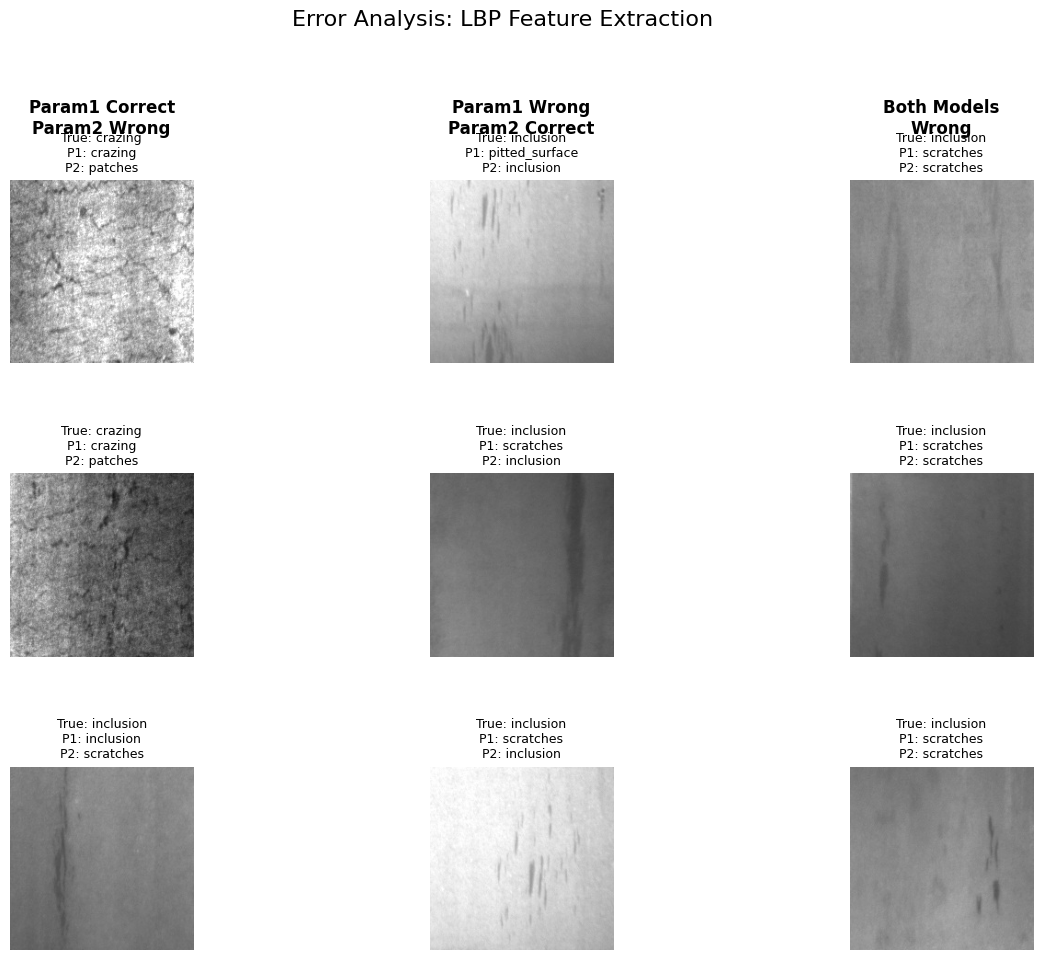


==================== Comparative Analysis for SIFT ====================


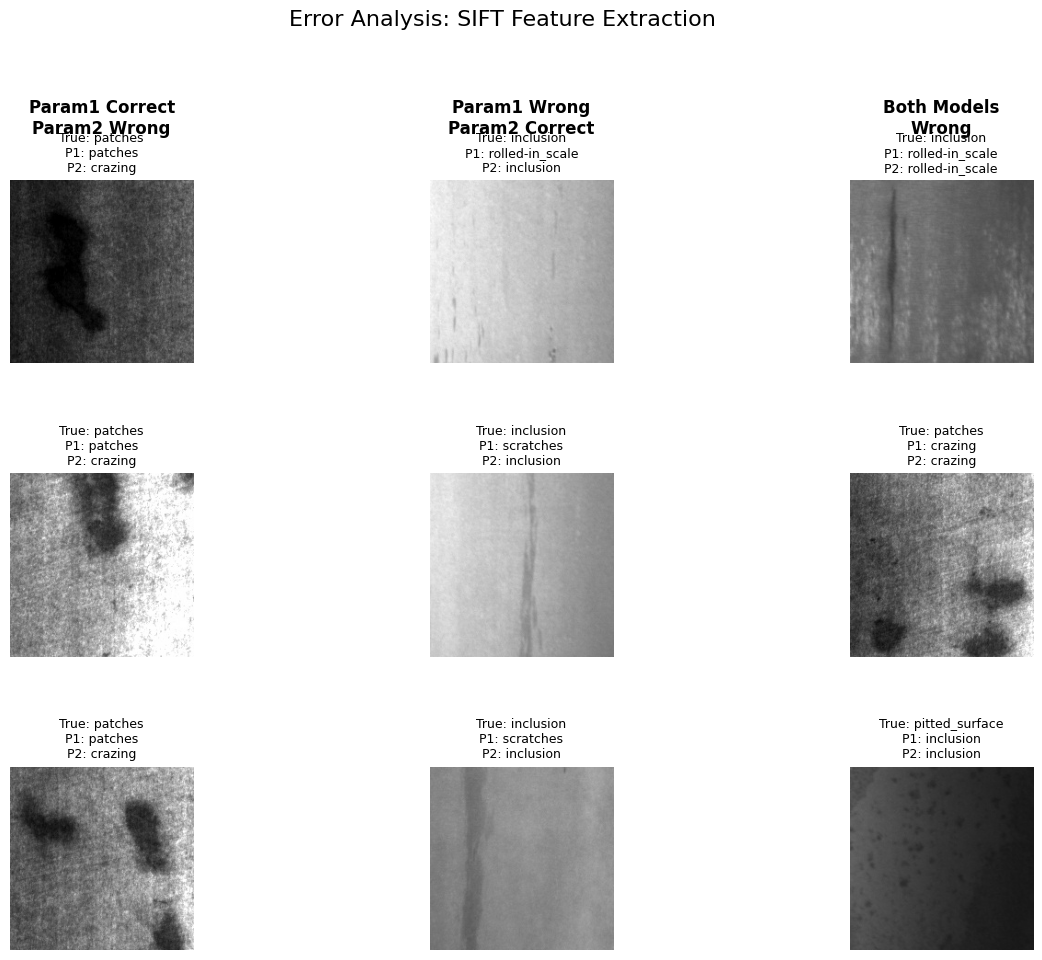

In [16]:
def visualize_comparative_errors(feature_method, scaled_data_dict):
    """
    Finds and visualizes 3 images for 3 specific scenarios:
    1. Param1 Correct, Param2 Wrong
    2. Param1 Wrong, Param2 Correct
    3. Both Wrong
    """
    print(f"\n{'='*20} Comparative Analysis for {feature_method} {'='*20}")
    
    # Retrieve models and make predictions
    p1_name = f"{feature_method}_param1"
    p2_name = f"{feature_method}_param2"
    
    model_p1 = optuna_results[p1_name]['model']
    model_p2 = optuna_results[p2_name]['model']
    
    # Get scaled test features based on the dictionary passed (lbp_scaled or sift_scaled)
    X_test_p1 = scaled_data_dict['param1']['test']
    X_test_p2 = scaled_data_dict['param2']['test']
    
    pred_p1 = model_p1.predict(X_test_p1)
    pred_p2 = model_p2.predict(X_test_p2)
    
    # Categorize indices
    case_p1_ok_p2_no = []
    case_p1_no_p2_ok = []
    case_both_no = []
    
    for i in range(len(y_test)):
        true_label = y_test[i]
        p1_label = pred_p1[i]
        p2_label = pred_p2[i]
        
        if p1_label == true_label and p2_label != true_label:
            case_p1_ok_p2_no.append(i)
        elif p1_label != true_label and p2_label == true_label:
            case_p1_no_p2_ok.append(i)
        elif p1_label != true_label and p2_label != true_label:
            case_both_no.append(i)
            
    # Helper to plot a column of images
    def plot_column(indices, col_idx, title_prefix):
        selected = indices[:3] # Take up to 3
        for row_idx, img_idx in enumerate(selected):
            ax = axes[row_idx, col_idx]
            
            # Load and process image for display
            img_path = X_test_paths[img_idx]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            ax.imshow(img)
            ax.axis('off')
            
            # Create title with predictions
            true_lbl = y_test[img_idx]
            p1_lbl = pred_p1[img_idx]
            p2_lbl = pred_p2[img_idx]
            
            color_p1 = 'green' if p1_lbl == true_lbl else 'red'
            color_p2 = 'green' if p2_lbl == true_lbl else 'red'
            
            ax.set_title(f"True: {true_lbl}\nP1: {p1_lbl}\nP2: {p2_lbl}", fontsize=9)
        
        # Set column title on the first row
        axes[0, col_idx].text(0.5, 1.25, title_prefix, 
                             size=12, ha="center", transform=axes[0, col_idx].transAxes, weight='bold')

    # Create plot
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    
    # Handle cases where we might not have 3 examples (fill empty axes)
    for ax_row in axes:
        for ax in ax_row:
            ax.axis('off')

    # Plot Case 1: Param1 Correct, Param2 Wrong
    if case_p1_ok_p2_no:
        plot_column(case_p1_ok_p2_no, 0, "Param1 Correct\nParam2 Wrong")
    else:
        axes[0, 0].set_title("No samples found", fontsize=10)

    # Plot Case 2: Param1 Wrong, Param2 Correct
    if case_p1_no_p2_ok:
        plot_column(case_p1_no_p2_ok, 1, "Param1 Wrong\nParam2 Correct")
    else:
        axes[0, 1].set_title("No samples found", fontsize=10)

    # Plot Case 3: Both Wrong
    if case_both_no:
        plot_column(case_both_no, 2, "Both Models\nWrong")
    else:
        axes[0, 2].set_title("No samples found", fontsize=10)

    plt.suptitle(f"Error Analysis: {feature_method} Feature Extraction", fontsize=16, y=1.05)
    plt.show()

# --- Execution ---

# 1. Visualize LBP Comparison
visualize_comparative_errors('LBP', lbp_scaled)

# 2. Visualize SIFT Comparison
visualize_comparative_errors('SIFT', sift_scaled)